## 4. Modeling 

#### Pakete laden

Alle benötigten Pakete kommen aus der Scikit-Learn (kurz auch sklearn). Das ist eine Python Bibliothek mit der sich Machine Learning Anwendungen einfach umsetzen lassen. Zu den bekanntesten Voraussetzung für die Verwendung von sklearn zählen Numpy und SciPy.

**train_test_split**: Um die Effektivität eines Machine-Learning-Modells zu überprüfen, wird der ursprüngliche Datensatz in zwei Sets aufgeteilt: ein Trainingsset und ein Testset. Das Trainingsset wird verwendet, um das Modell auf einem Teil der Daten zu fitten, d. h. zu trainieren. Das Testset wird verwendet, um die Leistung des Modells auf dem anderen Teil der Daten zu bewerten. 

**accuracy_score**: Berechnet die Genauigkeit des Modells, also den Anteil der korrekt klassifizierten Beispiele.

**classification_report**: Erzeugt einen Bericht, der Präzision, Recall und F1-Score für jedes Label im Klassifikationsproblem berechnet.

**confusion_matrix**: Erzeugt eine Verwirrungsmatrix, die die Leistung eines Klassifikators darstellt, indem sie die Anzahl der wahren und falschen Klassifikationen zeigt.   
Eine Confusion Matrix visualisiert die Leistung eines Klassifikationsmodells, indem die tatsächlichen und vorhergesagten Klassifikationen verglichen werden:

|               | Vorhergesagt Positiv      | Vorhergesagt Negativ     |
|---------------|--------------|-------------|
| Tatsächlich Positiv       |   TP         |   FN        |
| Tatsächlich Negativ       |   FP         |   TN        |

- **True Positives (TP)**: Die Anzahl der tatsächlichen positiven Fälle, die korrekt als positiv vorhergesagt wurden.
- **False Positives (FP)**: Die Anzahl der tatsächlichen negativen Fälle, die fälschlicherweise als positiv vorhergesagt wurden.
- **True Negatives (TN)**: Die Anzahl der tatsächlichen negativen Fälle, die korrekt als negativ vorhergesagt wurden.
- **False Negatives (FN)**: Die Anzahl der tatsächlichen positiven Fälle, die fälschlicherweise als negativ vorhergesagt wurden.  

**DecisionTreeClassifier / RandomForestClassifier**: Sie dienen dazu, Entscheidungsbaum-Modelle für Klassifikationsaufgaben zu erstellen und zu trainieren

**GridSearchCV / RandomizedSearchCV**: Sie werden zur Hyperparameter-Optimierung verwendet. Es hilft dabei, die besten Hyperparameter für ein Modell zu finden, indem es systematisch verschiedene Kombinationen von Hyperparametern testet und bewertet.

**plot_tree**: Wird zur grafischen Wiedergabe eines Entscheidungsbaums benötigt

In [124]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, precision_recall_curve, roc_curve, precision_score, recall_score, f1_score,  mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve
from sklearn.utils import shuffle
from sklearn.neighbors import NearestNeighbors

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import shap

import math

import xgboost as xgb
from xgboost import XGBClassifier
import sys

from scipy.stats import uniform, randint

#### Input: Bereinigte Daten von Data_Understanding_Preparation
Einlesen aus pickle file

In [125]:
# Der Datensatz employee_data_raw enthält den Datentyp "object", im Datensatz employee_data wurde der Datentyp "object" mittels One-Hot Encoding in Booleans umgewandelt

employee_data_raw = pd.read_pickle('../HR_Data_raw.pkl')
employee_data = pd.read_pickle('../HR_Data_One_Hot_Encoded.pkl')

Überprüfen ob die Spalten und Daten wie erwartet bereinigt sind. 

In [126]:
employee_data.tail()

,Attrition,Age,DistanceFromHome,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
1465,0,36,23,2,3,4,2,4,2571,4,...,0,0,0,0,0,0,1,0,1,0
1466,0,39,6,1,4,2,3,1,9991,4,...,0,0,0,0,0,0,1,0,1,0
1467,0,27,4,3,2,4,2,2,6142,1,...,1,0,0,0,0,0,1,0,0,1
1468,0,49,2,3,4,2,2,2,5390,2,...,0,0,0,1,0,0,1,0,1,0
1469,0,34,8,3,2,4,2,3,4404,2,...,0,0,0,0,0,0,1,0,1,0


#### Vorbereitung

Wir können einen Entscheidungsbaum relativ einfach dadurch trainieren, dass wir die Inputvariable X und die vorherzusagenden Klassen Y definieren und den Entscheidungsbaum aus Skicit-Learn darauf trainieren. 

1) Arrays, die aus dem zu teilenden Datensatz entnommen wurden.  
Beim überwachten Lernen sind diese Arrays das Input-Array X, das aus den erklärenden Variablen in den Spalten besteht, und das Output-Array y, das aus der Zielvariablen besteht. In diese Falle ist Attrition unsere Zielvariable, da dies vorhergesagt werden soll.

2) Split Trainings- und Testdaten

2.1) Die Größe des Testsets (test_size) und die Größe des Trainingssets (train_size).  
Die Größe jedes Satzes ist entweder eine Dezimalzahl zwischen 0 und 1, die einen Anteil des Datensatzes darstellt. Hier wählen wir als Trainingsgröße 30% unserers Datensatzes aus
Hinweis: Es ist ausreichend, nur eines dieser Argumente zu setzen, das zweite ist komplementär dazu.

2.2) Der random state (random_state).  
Der random state ist eine Zahl, die steuert, wie der Pseudo-Zufallsgenerator die Daten aufteilt.  
Hinweis: Wenn du eine ganze Zahl als random state wählst, werden die Daten bei jedem Aufruf der Funktion auf die gleiche Weise aufgeteilt. Dies macht den Code also reproduzierbar.   
[Warum "42"?](https://www.42-gmbh.de/unternehmen/warum-42/): Die Zahl 42 ist ein Insider-Witz in der Programmier- und Wissenschaftsgemeinschaft und stammt aus dem Buch "Per Anhalter durch die Galaxis" von Douglas Adams. In diesem Buch ist 42 die Antwort auf die ultimative Frage „nach dem Leben, dem Universum und allem“. Diese Antwort errechnet der größte existierende Computer in 7,5 Mio. Jahren:
![grafik.png](attachment:grafik.png)

In [133]:
#Aufteilen der Daten in Zielvariable X und Attribute Y.
X = employee_data.drop('Attrition', axis=1)
y = employee_data.Attrition

#Aufteilen der Daten in Test und Trainingsdaten.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [134]:
# Funktion zum Evaluieren der verschiedenen Modelle
def evaluation(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

#### FeatureImportance testen auf originalen Datensatz

In [129]:
employee_data_raw = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv', sep=',')
employee_data_raw.columns = employee_data_raw.columns.str.strip()

# Datenvorbereitung
categorical_col = []
for column in employee_data_raw.columns:
    if employee_data_raw[column].dtype == object:
        categorical_col.append(column)
for column in categorical_col:
    employee_data_raw[column] = employee_data_raw[column].astype("category").cat.codes
employee_data_raw['Attrition'] = employee_data_raw['Attrition'].astype("category").cat.codes

# Datenaufteilung
Xraw = employee_data_raw.drop('Attrition', axis=1).values  # Merkmale als NumPy-Array
yraw = employee_data_raw['Attrition'].values               # Zielvariable als NumPy-Array
Xraw_train, Xraw_test, yraw_train, yraw_test = train_test_split(Xraw, yraw, test_size=0.25, random_state=42)

# SimpleSMOTE-Klasse
class SimpleSMOTE:
    def __init__(self, sampling_strategy='auto', random_state=None):
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state

    def fit_resample(self, X, y):
        X, y = shuffle(X, y, random_state=self.random_state)
        X_minority = X[y == 1]
        n_minority = X_minority.shape[0]
        n_majority = X.shape[0] - n_minority
        if self.sampling_strategy == 'auto':
            self.sampling_strategy = n_majority / n_minority
        else:
            self.sampling_strategy = float(self.sampling_strategy)

        n_samples_to_generate = int(n_minority * (self.sampling_strategy - 1))
        nn = NearestNeighbors(n_neighbors=5).fit(X_minority)
        synthetic_samples = []
        for i in range(n_samples_to_generate):
            idx = np.random.randint(0, n_minority)
            neighbors = nn.kneighbors([X_minority[idx]], 5, return_distance=False)
            neighbor_idx = np.random.choice(neighbors[0][1:], size=1)[0]
            diff = X_minority[neighbor_idx] - X_minority[idx]
            synthetic_sample = X_minority[idx] + np.random.rand() * diff
            synthetic_samples.append(synthetic_sample)
        X_synthetic = np.array(synthetic_samples)
        y_synthetic = np.ones(X_synthetic.shape[0])
        return np.vstack((X, X_synthetic)), np.concatenate((y, y_synthetic))

# Anwendung von SimpleSMOTE auf die Trainingsdaten
smote = SimpleSMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(Xraw_train, yraw_train)

# Zählen der Anzahl der "Yes"-Labels (Attrition = 1) vor SMOTE
num_yes_before = np.sum(y_train == 1)
print(f"Anzahl der 'Yes' (Attrition = 1) vor SMOTE: {num_yes_before}")
num_yes_after = np.sum(y_resampled == 1)
print(f"Anzahl der 'Yes' (Attrition = 1) nach SMOTE: {num_yes_after}")
#Entscheidungsbaum
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(Xraw_train, yraw_train)

# Feature Wichtigkeit Roh-Daten ausgeben
feature_importances = tree_clf.feature_importances_
feature_names = employee_data_raw.drop('Attrition', axis=1).columns
feature_importance_employee_data_raw = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:\n", feature_importance_employee_data_raw)

Anzahl der 'Yes' (Attrition = 1) vor SMOTE: 176
Anzahl der 'Yes' (Attrition = 1) nach SMOTE: 913

Feature Importances:
                      Feature  Importance
17             MonthlyIncome    0.136488
21                  OverTime    0.075114
2                  DailyRate    0.066220
0                        Age    0.060333
27         TotalWorkingYears    0.056614
18               MonthlyRate    0.053068
32   YearsSinceLastPromotion    0.052615
16             MaritalStatus    0.048794
11                HourlyRate    0.048012
4           DistanceFromHome    0.040587
31        YearsInCurrentRole    0.039619
19        NumCompaniesWorked    0.032075
9    EnvironmentSatisfaction    0.029499
24  RelationshipSatisfaction    0.024987
28     TrainingTimesLastYear    0.023433
8             EmployeeNumber    0.023239
12            JobInvolvement    0.022792
30            YearsAtCompany    0.022601
26          StockOptionLevel    0.020638
15           JobSatisfaction    0.018544
3                 D

#### 1. Decision Trees und Random Forest

Erste Klassifizierung mit Trainings- und Testdaten für den Decision Tree.

In [139]:
X_test

,Age,DistanceFromHome,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,RelationshipSatisfaction,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
1041,28,5,3,4,3,2,1,8463,0,4,...,0,0,0,1,0,0,0,1,1,0
184,53,13,2,4,4,2,1,4450,1,3,...,1,0,0,0,0,1,0,0,1,0
1222,24,22,1,4,1,1,3,1555,1,3,...,0,0,0,0,0,0,1,0,1,0
67,45,7,3,2,3,3,1,9724,2,3,...,0,0,1,0,0,1,0,0,1,0
220,36,5,2,4,3,2,2,5914,8,4,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047,33,7,3,4,3,2,1,4373,0,1,...,0,0,0,1,0,0,1,0,1,0
331,27,1,1,3,3,2,2,6349,0,4,...,0,0,0,1,0,0,1,0,0,1
323,28,2,4,1,1,1,4,3464,5,4,...,0,0,1,0,0,0,1,0,0,1
654,39,2,3,4,2,2,4,5204,8,3,...,0,0,0,0,0,0,1,0,1,0


In [141]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

evaluation(tree_clf, X_train,  y_train, X_test,y_test, train=True)
evaluation(tree_clf, X_train,  y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    853.0  176.0       1.0     1029.0        1029.0
_______________________________________________
Confusion Matrix: 
 [[853   0]
 [  0 176]]

Test Result:
Accuracy Score: 79.59%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.885638   0.276923  0.795918    0.581281      0.801440
recall       0.876316   0.295082  0.795918    0.585699      0.795918
f1-score     0.880952   0.285714  0.795918    0.583333      0.798618
support    380.000000  61.000000  0.795918  441.000000    441.000000
_______________________________________________
Conf

Die Feature Importance gibt an, nach welchen Variablen sich der Decision Tree für die Klassifizierung der Mitarbeitenden entscheidet. Mit viel Abstand wird dabei der MonthlyIncome als wichtigste Kennzahl bewertet. In etwas Abstand folgen dann EnvironmentSatisfaction, TotalWorkingYears, OverTime und DistanceFromHome.

In [142]:
# Feature Wichtigkeit bereinigte Daten ausgeben
feature_importances = tree_clf.feature_importances_
feature_names = employee_data.drop('Attrition', axis=1).columns
feature_importance_employee_data = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:\n", feature_importance_employee_data)


Feature Importances:
                               Feature  Importance
7                       MonthlyIncome    0.147996
0                                 Age    0.074792
11                  TotalWorkingYears    0.074720
38                       OverTime_Yes    0.074690
1                    DistanceFromHome    0.073970
36               MaritalStatus_Single    0.056188
15            YearsSinceLastPromotion    0.051873
13                     YearsAtCompany    0.051080
3             EnvironmentSatisfaction    0.042994
8                  NumCompaniesWorked    0.042129
2                           Education    0.037595
6                     JobSatisfaction    0.032390
9            RelationshipSatisfaction    0.030007
18   BusinessTravel_Travel_Frequently    0.025652
16               YearsWithCurrManager    0.024062
12                    WorkLifeBalance    0.022671
5                            JobLevel    0.020575
4                      JobInvolvement    0.020007
31         JobRole_Research

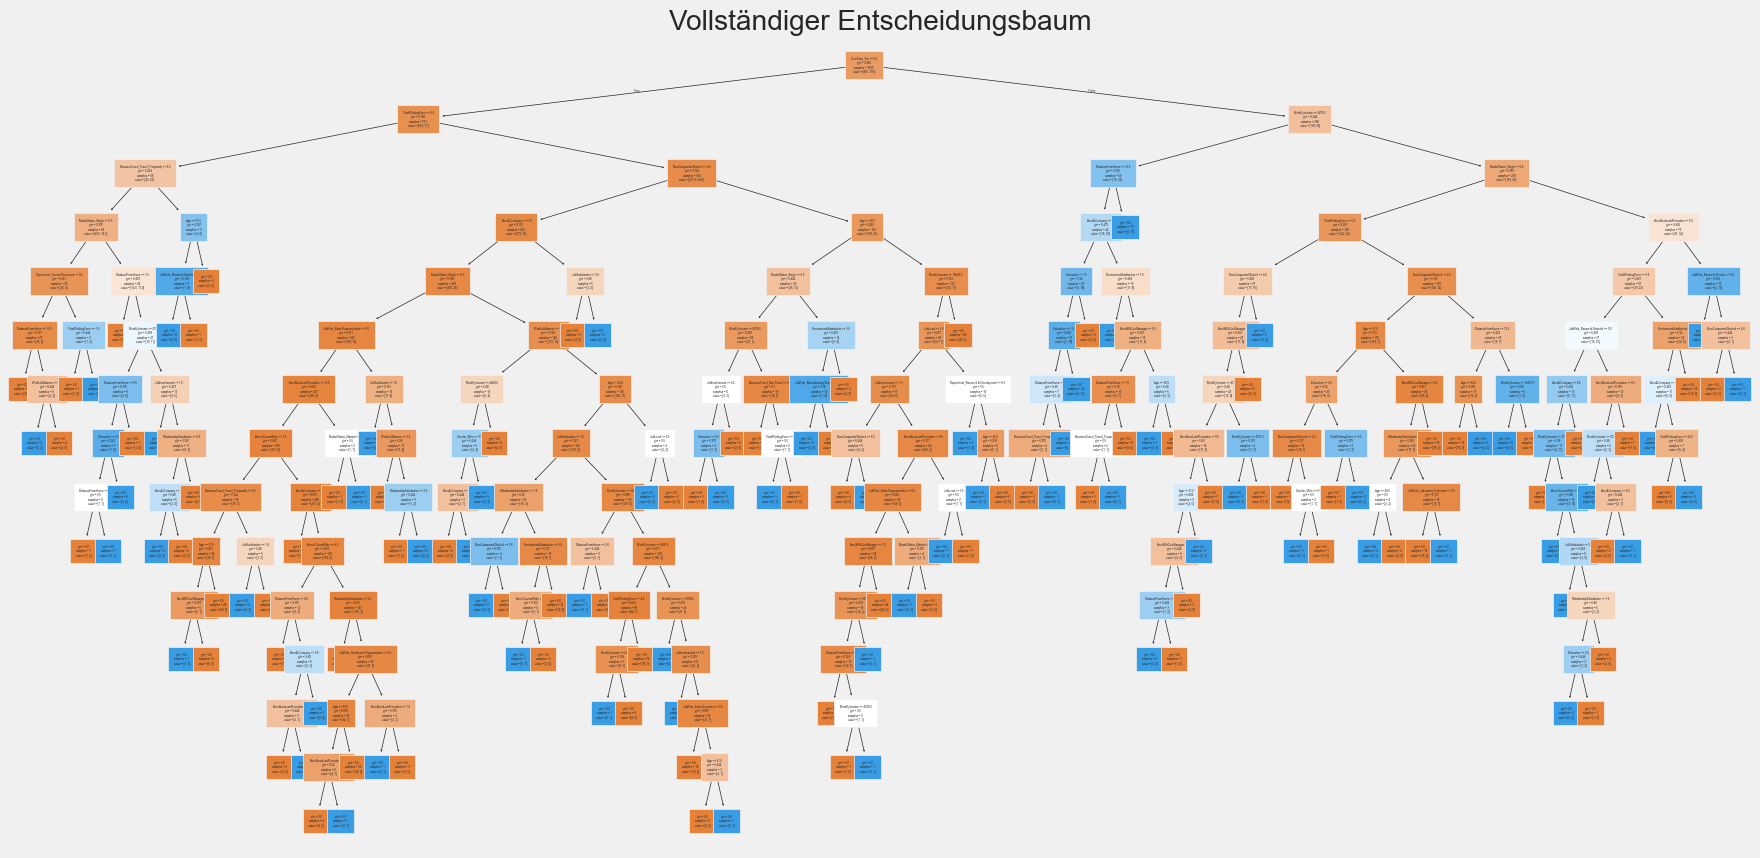

In [143]:
#Entscheidungsbaum visualisieren
plt.figure(figsize=(20, 10))
plot_tree(tree_clf, feature_names=feature_names, filled=True, fontsize=2)
plt.title("Vollständiger Entscheidungsbaum")
plt.show()

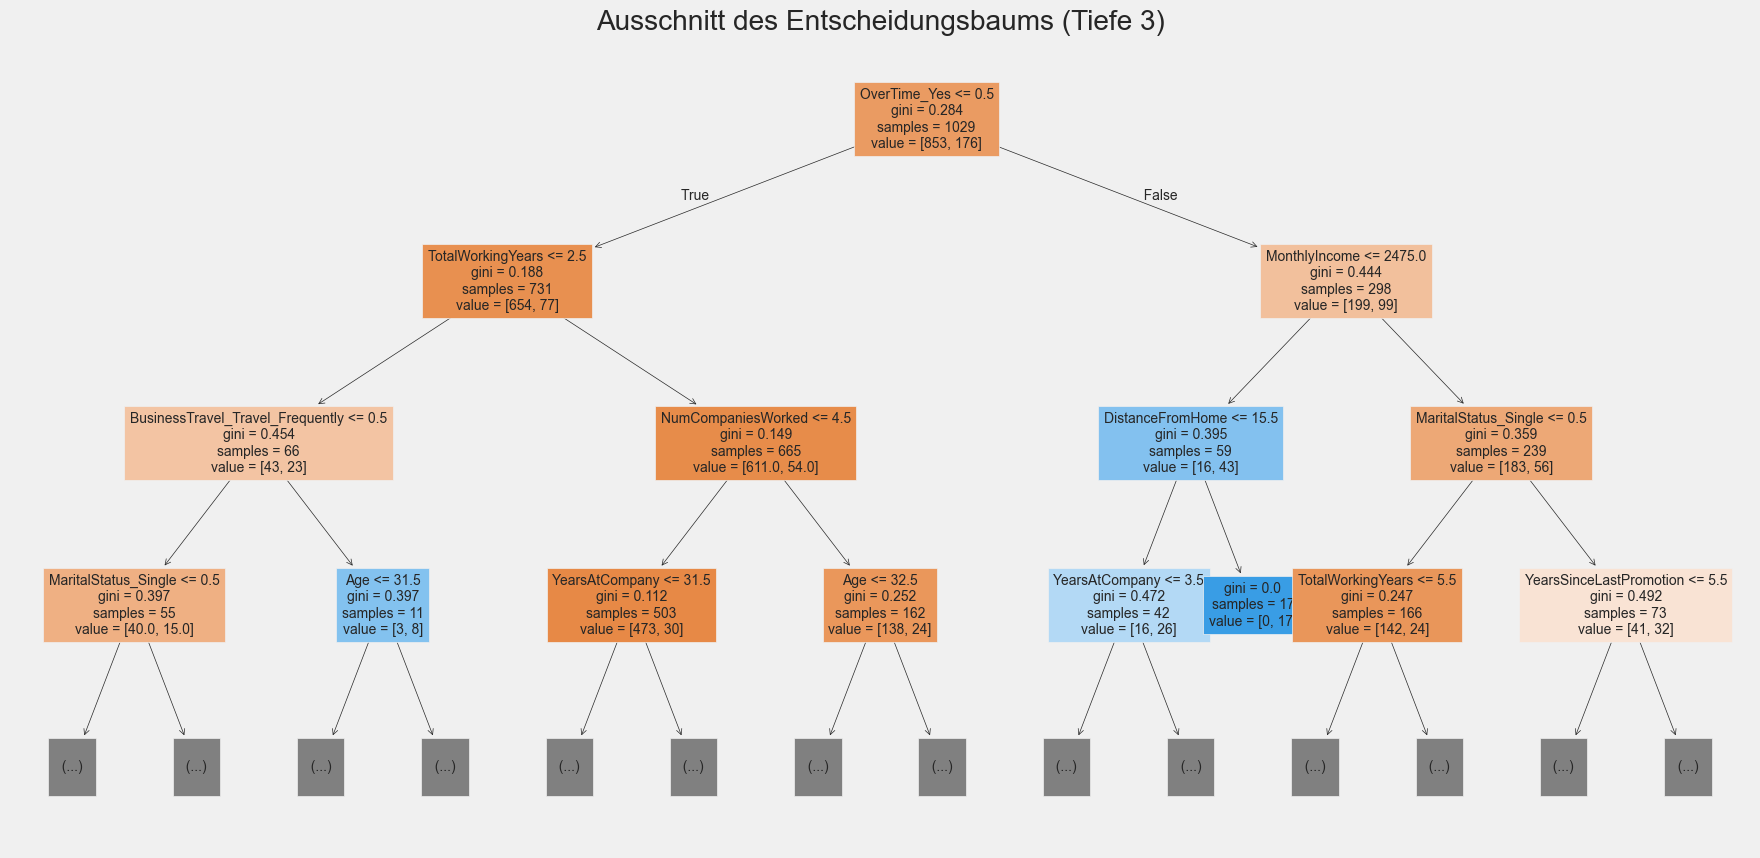

In [144]:
# Ausschnitt des Entscheidungsbaums visualisieren (z.B. nur bis Tiefe 3)
plt.figure(figsize=(20, 10))
plot_tree(tree_clf, feature_names=feature_names, filled=True, fontsize=10, max_depth=3)
plt.title("Ausschnitt des Entscheidungsbaums (Tiefe 3)")
plt.show()

**Parametertuning**

Tuning eines Einzelnen Entscheidungsbaums kann Ihnen helfen, ein Gefühl dafür zu bekommen, welche Parameterbereiche sinnvoll sind und wie der baum auf unterscheidliche Variablen reagiert. Dies kann indirekt Informationen für die Random Forest-Konfiguration liefern.

DecisionTree Parameter:

criterion{“gini”, “entropy”, “log_loss”}, default=”gini”   
Die Funktion zur Messung der Qualität einer Aufteilung. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain. Unterstützte Kriterien sind "gini" für die Gini-Verunreinigung und "entropy" für den Informationsgewinn. Beim Informationsgewinn wird das Entropiemaß als Maß für die Unreinheit verwendet und ein Knoten wird so aufgeteilt, dass er den größten Informationsgewinn bietet. Die Gini-Unreinheit hingegen misst die Divergenzen zwischen den Wahrscheinlichkeitsverteilungen der Werte des Zielattributs und teilt einen Knoten so auf, dass er die geringste Unreinheit ergibt.

splitter{“best”, “random”}, default=”best”   
Die Strategie, die für die Auswahl des Splits an jedem Knoten verwendet wird. Unterstützte Strategien sind "best" für die Auswahl des besten Splits und "random" für die Auswahl des besten zufälligen Splits.

max_depthint, default=None
Die maximale Tiefe des Baums. Falls keine, werden die Knoten so lange erweitert, bis alle Blätter rein sind oder bis alle Blätter weniger als min_samples_split Stichproben enthalten.

min_samples_splitint or float, default=2   
Die Mindestanzahl von Stichproben, die erforderlich ist, um einen internen Knoten zu teilen.
Wenn int, dann gilt min_samples_split als Mindestanzahl.
Wenn float, dann ist min_samples_split ein Bruch und ceil(min_samples_split * n_samples) ist die Mindestanzahl von Stichproben für jeden Split.

min_samples_leafint or float, default=1   
Die Mindestanzahl von Stichproben, die erforderlich ist, um einen Blattknoten zu erreichen. Ein Aufteilungspunkt in beliebiger Tiefe wird nur berücksichtigt, wenn er mindestens min_samples_leaf Trainingsstichproben in jedem der linken und rechten Zweige hinterlässt. Dies kann zu einer Glättung des Modells führen, insbesondere bei Regressionen.
Die Mindestanzahl von Stichproben, die für einen Blattknoten erforderlich sind. Ein Splitpunkt in beliebiger Tiefe wird nur berücksichtigt, wenn er mindestens min_samples_leaf Trainingsstichproben in jedem der linken und rechten Zweige hinterlässt. Dies kann zu einer Glättung des Modells führen, insbesondere bei Regressionen.
Wenn int, dann wird min_samples_leaf als Mindestanzahl betrachtet.
Wenn float, dann ist min_samples_leaf ein Bruch und ceil(min_samples_leaf * n_samples) ist die Mindestanzahl von Stichproben für jeden Knoten.

In [145]:
# Manuelle Festlegung der Parameter
manual_params = {
    "criterion": "gini",        # "gini" oder "entropy" oder "log_loss"
    "splitter": "best",         # "best" oder oder "random"
    "max_depth": 10,            # Wertebereich ab 1
    "min_samples_split": 2,     # Wertebereich ab 2
    "min_samples_leaf": 2       # Wertebereich ab 1
}

# Entscheidung für das Modell mit den festgelegten Parametern
tree_clf = DecisionTreeClassifier(random_state=42, **manual_params)
tree_clf.fit(X_train, y_train)

evaluation(tree_clf, X_train, y_train, X_test, y_test, train=True)
evaluation(tree_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 96.40%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.960497    0.986014  0.964043     0.973255      0.964861
recall       0.997655    0.801136  0.964043     0.899396      0.964043
f1-score     0.978723    0.884013  0.964043     0.931368      0.962524
support    853.000000  176.000000  0.964043  1029.000000   1029.000000
_______________________________________________
Confusion Matrix: 
 [[851   2]
 [ 35 141]]

Test Result:
Accuracy Score: 83.90%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.891139   0.391304  0.839002    0.641222      0.822001
recall       0.926316   0.295082  0.839002    0.610699      0.839002
f1-score     0.908387   0.336449  0.839002    0.622418      0.829275
support    380.000000  61.000000  0.839002  441.000000    441.

**Grid Search Cross Validation**

Aschließend folgt die Parameteroptimierung über GridSearchCV, um die optimale Kombination zu erhatlen.

Die Kreuzvalidierung ist eine bekannte Technik im Bereich des Machine Learning und hilft zu verstehen, wie gut ein Modell auf ungesehene Daten reagiert. Sie kann genauso auch für das Hyperparameter Tuning verwendet werden, um verschiedene Parametereinstellungen zu testen und zu vergleichen. Die Cross Validation nutzt eine sogenannte Resampling-Technik bei der der Datensatz in mehrere Teilmengen unterteilt wird. Die verbreiteste Umsetzung ist dabei die k-fold Cross Validation, bei der insgesamt k Teilmengen gebildet werden. Dabei wird in jeder Iteration eine andere Menge als Validierungsdatensatz genutzt, um eine unabhängige Aussage über die Leistung des Modells treffen zu können. 

In vielen Fällen wird dafür der folgende Prozess genutzt: 

Partitionierung der Daten: Der Datensatz wird als erstes in die gleich großen Teilmengen gesplittet. Diese fungieren während dem Trainings entweder als Trainings- oder Validierungssatz. Die unterschiedlichen Validierungssätze können dann genutzt werden, um die Modellleistung unabhängig bewerten und vergleichen zu können.   

Auswahl von Hyperparametern: Vor dem Training wird ein Satz an Hyperparametern festgelegt, der in dieser Iteration getestet werden soll. Dies wurde durch die manuellen Anapssungen der Parameter erzielt.

Aggregieren der Ergebnisse: Anschließend können die Ergebnisse zusammengefasst werden, um ein optimales Set an Hyperparameter zu bestimmen.

Als optimal wird dabei nicht unbedingt die Auswahl betrachtet, die den höchsten Accuracy Score hat, sondern, die auch in den weiteren Kennzahlen performt. Dadurch wird zum Beispiel eine ungleichverteilung der Klassen vermieden, sodass die Vorhersage nicht meist auf "Mitarbeitende bleiben im Unternehmen" hinausläuft. Diese "Falschaussage" ist problematisch, da die Grundannahme der Personalabteilung lautet, dass die Mitarbeitenden bleiben und somit potenzielle Abgänge nicht erkannt werden, die durch eine korrekte Vorhersage verhindert hätten werden können.

In [146]:
params = {
    "criterion":("gini", "entropy", "log_loss"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4, 5, 6, 7, 8, 9, 10], 
    "min_samples_leaf":list(range(1, 20)), 
}


tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(
    tree_clf, 
    params, 
    scoring="f1", 
    n_jobs=-1, 
    verbose=1, 
    cv=5
)

tree_cv.fit(X_train, y_train)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(X_train, y_train)
evaluation(tree_clf, X_train, y_train, X_test, y_test, train=True)
evaluation(tree_clf, X_train, y_train, X_test, y_test, train=False)

Fitting 5 folds for each of 19494 candidates, totalling 97470 fits
Best paramters: {'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 9, 'min_samples_split': 2, 'splitter': 'random'})
Train Result:
Accuracy Score: 87.95%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.894054    0.750000  0.879495     0.822027      0.869415
recall       0.969519    0.443182  0.879495     0.706351      0.879495
f1-score     0.930259    0.557143  0.879495     0.743701      0.866441
support    853.000000  176.000000  0.879495  1029.000000   1029.000000
_______________________________________________
Confusion Matrix: 
 [[827  26]
 [ 98  78]]

Test Result:
Accuracy Score: 85.49%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.883495   0.448276  0.854875    0.665886      0.823295
recall  

Erste Klassifizierung mit Trainings- und Testdaten für Random Forrest

In [147]:
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)

evaluation(tree_clf, X_train, y_train, X_test, y_test, train=True)
evaluation(tree_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 87.95%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.894054    0.750000  0.879495     0.822027      0.869415
recall       0.969519    0.443182  0.879495     0.706351      0.879495
f1-score     0.930259    0.557143  0.879495     0.743701      0.866441
support    853.000000  176.000000  0.879495  1029.000000   1029.000000
_______________________________________________
Confusion Matrix: 
 [[827  26]
 [ 98  78]]

Test Result:
Accuracy Score: 85.49%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.883495   0.448276  0.854875    0.665886      0.823295
recall       0.957895   0.213115  0.854875    0.585505      0.854875
f1-score     0.919192   0.288889  0.854875    0.604040      0.832007
support    380.000000  61.000000  0.854875  441.000000    441.

**Parametertuning**

Für Random Forests ist es üblich, GridSearchCV oder RandomizedSearchCV zu verwenden, um die optimale Kombinationen von Hyperparametern zu verwenden und das beste Modell auszuwählen.

Random Forest Parameter:

n_estimators: Die Anzahl der Bäume im Wald.

criterion: Die Funktion zur Messung der Qualität einer Aufteilung. Unterstützte Kriterien sind "gini" für die Gini-Unreinheit und "entropy" für den Informationsgewinn.

max_depth: Die maximale Tiefe des Baums. Falls keine, werden die Knoten so lange expandiert, bis alle Blätter rein sind oder bis alle Blätter weniger als min_samples_split samples enthalten.

min_samples_split: Die Mindestanzahl von Stichproben, die erforderlich ist, um einen internen Knoten zu teilen.

min_samples_leaf: Die Mindestanzahl von Stichproben, die erforderlich ist, um einen Blattknoten zu erreichen. Ein Aufteilungspunkt in beliebiger Tiefe wird nur berücksichtigt, wenn er mindestens min_samples_leaf Trainingsstichproben in jedem der linken und rechten Zweige hinterlässt. Dies kann zu einer Glättung des Modells führen, insbesondere bei Regressionen.

min_weight_fraction_leaf: Der minimale gewichtete Anteil der Gesamtsumme der Gewichte (aller Eingabestichproben), der an einem Blattknoten liegen muss. Wenn sample_weight nicht angegeben wird, haben die Stichproben das gleiche Gewicht.

max_features: Die Anzahl der Merkmale, die bei der Suche nach dem besten Split berücksichtigt werden solle

max_leaf_nodes: Wachsen lassen eines Baumes mit max_leaf_nodes in best-first fashion. Die besten Knoten werden als relative Verringerung der Unreinheit definiert. Wenn Keine, dann unbegrenzte Anzahl von Blattknoten.

min_impurity_decrease: Ein Knoten wird geteilt, wenn dieser Split eine Verringerung der Unreinheit von mindestens diesem Wert bewirkt.

min_impurity_split: Schwellenwert für das vorzeitige Anhalten des Baumwachstums. Ein Knoten wird geteilt, wenn seine Unreinheit über dem Schwellenwert liegt, andernfalls bleibt er ein Blatt.

bootstrap: Ob bei der Erstellung von Bäumen Bootstrap-Stichproben verwendet werden. Wenn False, wird der gesamte Datensatz zur Erstellung jedes Baums verwendet.

oob_score: Ob Out-of-Bag-Stichproben verwendet werden sollen, um die Generalisierungsgenauigkeit zu schätzen.

In [148]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators, 
    'max_features': max_features,
    'max_depth': max_depth, 
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf, 
    'bootstrap': bootstrap
}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = RandomizedSearchCV(
    estimator=rf_clf, 
    scoring='f1',
    param_distributions=random_grid, 
    n_iter=200, 
    cv=5, 
    verbose=1, 
    random_state=42,
    n_jobs=-1
)

rf_cv.fit(X_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(X_train, y_train)

evaluation(tree_clf, X_train, y_train, X_test, y_test, train=True)
evaluation(tree_clf, X_train, y_train, X_test, y_test, train=False)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\vanes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
460 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
334 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\vanes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\vanes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-

Best paramters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False})
Train Result:
Accuracy Score: 87.95%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.894054    0.750000  0.879495     0.822027      0.869415
recall       0.969519    0.443182  0.879495     0.706351      0.879495
f1-score     0.930259    0.557143  0.879495     0.743701      0.866441
support    853.000000  176.000000  0.879495  1029.000000   1029.000000
_______________________________________________
Confusion Matrix: 
 [[827  26]
 [ 98  78]]

Test Result:
Accuracy Score: 85.49%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.883495   0.448276  0.854875    0.665886      0.823295
recall       0.957895   0.213115  0.854875    0.58550

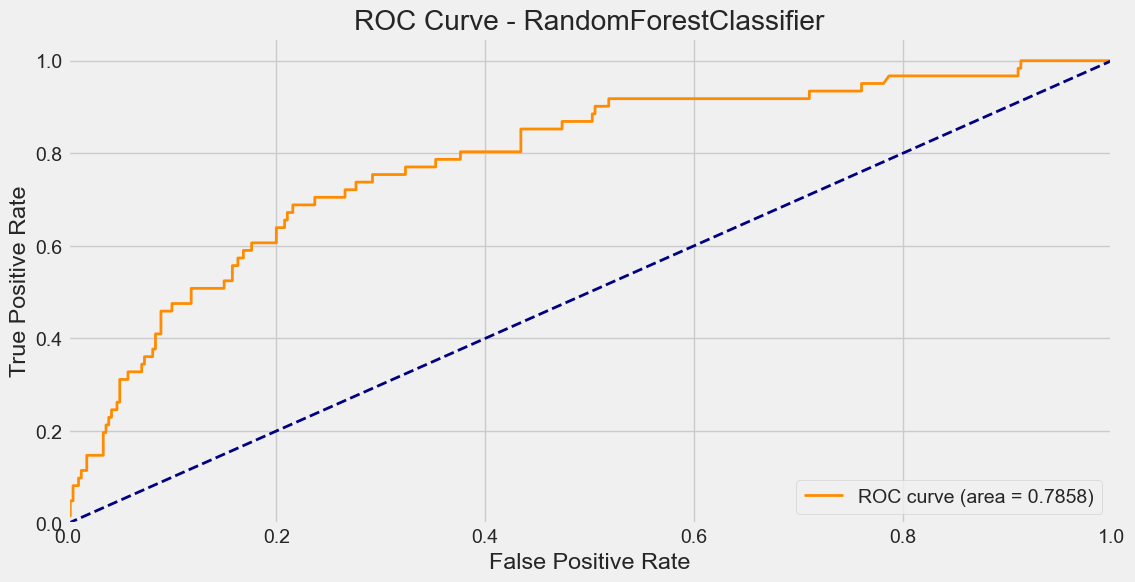

In [149]:
# Berechnen der ROC-Kurve und AUC für den RandomForestClassifier
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

# Plotten der ROC-Kurve für RandomForestClassifier
plt.figure(figsize=(12, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RandomForestClassifier')
plt.legend(loc="lower right")
plt.show()

#### 2. XGBoost

Ein weiterer, auf Entscheidungsbäume basierender Lernalgorithmus ist der sogenannte XGBoost (eXtreme Gradient Boosting). XGBoost unterstützt sowohl die Lösung von Klassifikations- als auch Regressionsaufgaben. Ähnlich dem Random Forest Algorithmus wird die Vorhersagegenauigkeit durch Kombination verschiedener Entscheidungsbäume erhöht, allerdings werden diese nicht unabhängig voneinander erstellt. Zur schrittweisen Verbesserung der Modelle auf Basis der Residuen nutzt XGBoost Gradient Boosting. So wird die Verlustfunktion während des Trainingsprozesses optimiert. Der Algorithmus bietet außerdem zahlreiche Hyperparameter zur Verbesserung der Modellleistung. Darunter auch Regularisierungstechniken wie L1- und L2 um Overfitting zu vermeiden und die Modellkompelxität zu kontrollieren. Nebst Anpassungsmöglichkeiten liegen die Stärken von XGBoost vor allem in der Parallelisierung und somit im effizienten Umgang mit großen Datensätze. Obwohl der Algorithmus Mechanismen zur Reduzierung von Overfitting bietet, kann die Vielschichtigkeit des Hyperparameter-Tunings dennoch zu Überanpassung führen. Außerdem ist die Interpretierbarkeit aufgrund der Komplexität eingeschränkt (Chen et al. 2014).

##### 2.1 Daten für das Training vorbereiten:

1. Zielvariable zunächst als "category" und dann in numerische Werte (binär in 0 und 1) umwandeln.

In [150]:
# Erstellen und Trainieren des XGBoost Modells

# 1. Zielvariable in numerische Codes umwandeln (Yes --> 1, No --> 0)
if y_train.dtype == 'object':
    y_train = y_train.astype('category')
    y_train = y_train.cat.codes

if y_test.dtype == 'object':
    y_test = y_test.astype('category')
    y_test = y_test.cat.codes


##### 2.2 Hyperparameter definieren und Modell trainieren:

Zur Festlegung der Hyperparameter stehen unterschiedliche Ansätze zur Verfügung. Darunter **Grid Search** und **Random Search** (s. Gliederungspunkt 2.3)
Zunächst wird das Modell allerdings nur mit den folgenden 5 Parametern trainiert, die auf einen Standard-Wert festgelgt werden:

- *"objective"*: binäres Klassifikationsproblem mit einer logistischen Regression.
- *"max_depth"*: Maximale Tiefe jedes Entscheidungsbaum. Ein höherer Wert ermöglich komplexere Werte (Achtung: Overfitting).
- *"learning_rate"*: legt die Lernrate fest und steuert die Schrittweite des Gradientabstiegs.Ziel des Gradientenabstiegs ist das Finden der optimalen Werte der Modellparameter zur Minimierung der **Loss Function** (Misst Fehler zwischen vorhergesagten und tatsächlichen Werten, z.B. Mean Squared Error bei linearen Regression oder Log-Loss bei binären Klassifikation). Ein niedriger Werte macht Modell robust ggü. Overfitting (Achtung: mehr Iterationen nötig).
- *"n_estimators"*: Anzahl der Boosting-Runden. Jede Boosting-Runde (sequenzielles Training) fügt neuen Entscheidungsbaum hinzu und korrigiert die Fehler (Residuen) des vorherigen Baumes. Idee: Kombination vieler schwacher Modelle ergibt starkes Lernmodell.
- *"eval_metric"*: Metrik zur Evaluierung des Modells. "logloss" steht für logarithmischer Verlust (Logarithmic Loss) und bewertet wie gut das Klassifikationsmodell Wahrscheinlichkeiten für die Klassen vorhersagt. Beispiel einer "guten" Vorhersage: Tatsächliches Label ist 1 und Modell sagt Wahrscheinlichkeit von 0,9 vorher. Dann ist Log Loss relativ klein. Hier wird "logloss" als Evaluationsmetrik verwendet um Leistung des Modells während des Trainings zu bewerten (Ziel: Minimierung des logarithmischen Verlustes).


In [151]:
# Erstellen und Trainieren des XGBoost-Modells mit XGBClassifier
xgb_model = XGBClassifier(objective='binary:logistic', max_depth=6, learning_rate=0.3, n_estimators=100, eval_metric='logloss')
# xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Vorhersagen mit dem Modell
xgb_preds = xgb_model.predict(X_test)
xgb_y_pred = (xgb_preds > 0.5).astype(int)


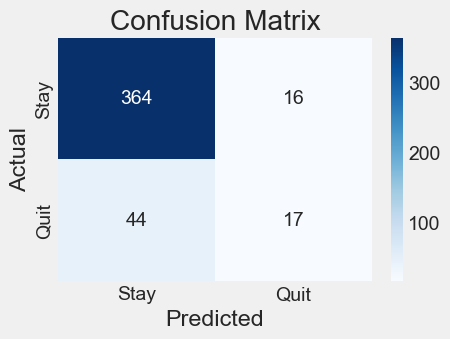

In [152]:
conf_matrix = confusion_matrix(y_test, xgb_y_pred)
plt.figure(figsize=(4.5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Stay', 'Quit'], yticklabels=['Stay', 'Quit'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [153]:
evaluate(xgb_model, X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[853   0]
 [  0 176]]
ACCURACY SCORE:
1.0000
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    853.0  176.0       1.0     1029.0        1029.0
TESTING RESULTS: 
CONFUSION MATRIX:
[[364  16]
 [ 44  17]]
ACCURACY SCORE:
0.8639
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.892157   0.515152  0.863946    0.703654      0.840009
recall       0.957895   0.278689  0.863946    0.618292      0.863946
f1-score     0.923858   0.361702  0.863946    0.642780      0.846099
support    380.000000  61.000000  0.863946  441.000000    441.000000


##### 2.3 Hyperparameter Tuning

Mit Hilfe von GridSearchCV kann aus einer Auswahl von Parametern die ideale Kombination ermittelt werden. 
Durch Verwendung von RandomSearchCV kann durch die Festlegung von Iterationen eine zufällig ideale Parameterkombination ermittelt werden.

- *max_depth:* Steuert, wie tief jeder einzelne Entscheidungsbaum wachsen kann. Größere Werte können zu komplexeren Modellen führen.
- *learning_rate (eta):* Kleinere Werte machen das Training langsamer, aber stabiler. Ein niedrigerer Wert erfordert oft mehr n_estimators.
- *n_estimators:* Gibt an, wie viele Bäume im Modell trainiert werden. Mehr Bäume können zu besseren Modellen führen, aber auch die Rechenzeit erhöhen.
- *subsample:* Der Anteil der Trainingsdaten, die für jede Boosting-Runde zufällig ausgewählt werden. Reduziert Overfitting, Werte zwischen 0.5 und 1.0 sind üblich.
- *colsample_bytree:* Der Anteil der Merkmale, die für das Training jedes Baumes zufällig ausgewählt werden. Reduziert Overfitting, indem es die Vielfalt der Bäume erhöht. Werte zwischen 0.5 und 1.0 sind üblich.
- *reg_alpha (alpha):* L1-Regularisierungsterm, der eine Strafe für die Summe der absoluten Werte der Koeffizienten hinzufügt. Fördert Sparsamkeit im Modell, indem es einige Koeffizienten auf genau Null setzt, was effektiv einer Feature-Auswahl entspricht und Overfitting reduziert.
- *reg_lambda (lambda):* L2-Regularisierungsterm, der eine Strafe für die Summe der Quadrate der Koeffizienten hinzufügt. Stabilisiert das Modell, indem es alle Koeffizienten schrumpft, um Überanpassung zu reduzieren, ohne sie auf Null zu setzen, was zu einem glatteren und weniger komplexen Modell führt.
- *gamma:* Mindesteste Verlustreduktion, die erforderlich ist, um eine Baumaufspaltung durchzuführen. Höhere Werte führen dazu, dass weniger Splits durchgeführt werden, was zu einfacheren und weniger overfitted Modellen führt.

In [154]:
# Random Search: Definiere Parametergrenzen
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'scale_pos_weight': randint(1, 10),
    'learning_rate': uniform(0.01, 0.5),
    'subsample': uniform(0, 1),
    'colsample_bytree': uniform(0, 1),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# RandomizedSearchCV starten, n_iter gibt an, wieviele Iterationen durchgeführt werden
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=1,
    n_jobs=-1
)

# Fit
random_search.fit(X_train, y_train)

print(f"Best Parameter: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameter: {'colsample_bytree': 0.4672458239265538, 'learning_rate': 0.16738284366200823, 'max_depth': 8, 'n_estimators': 59, 'reg_alpha': 0.8773604746948126, 'reg_lambda': 0.4476890001456285, 'scale_pos_weight': 1, 'subsample': 0.4629964340997167}
Best Score: 0.8717201166180759


Es wurden verschiedene Parameterkonfigurationen getestet. Dabei wurde nie ein besserer Score erreicht als mit den Standardparametern.

##### 2.4 Visualisierung der Modellperformance

Die *ROC-Curve* (Receiver Operating Characteristic) ist ein Tool zur Bewertung der Leistung eines binären Klassifikationsmodells. Sie stellt die wahre positive Rate (True Positive Rate, TPR) gegenüber der falschen positiven Rate (False Positive Rate, FPR) dar, um die Trennschärfe des Modells bei verschiedenen Schwellenwerten zu visualisieren

In [155]:
# Berechnen der FPR, TPR und AUC
fpr_xgb_model, tpr_xgb_model, _ = roc_curve(y_test, xgb_preds)
roc_auc_xgb_model = roc_auc_score(y_test, xgb_preds)

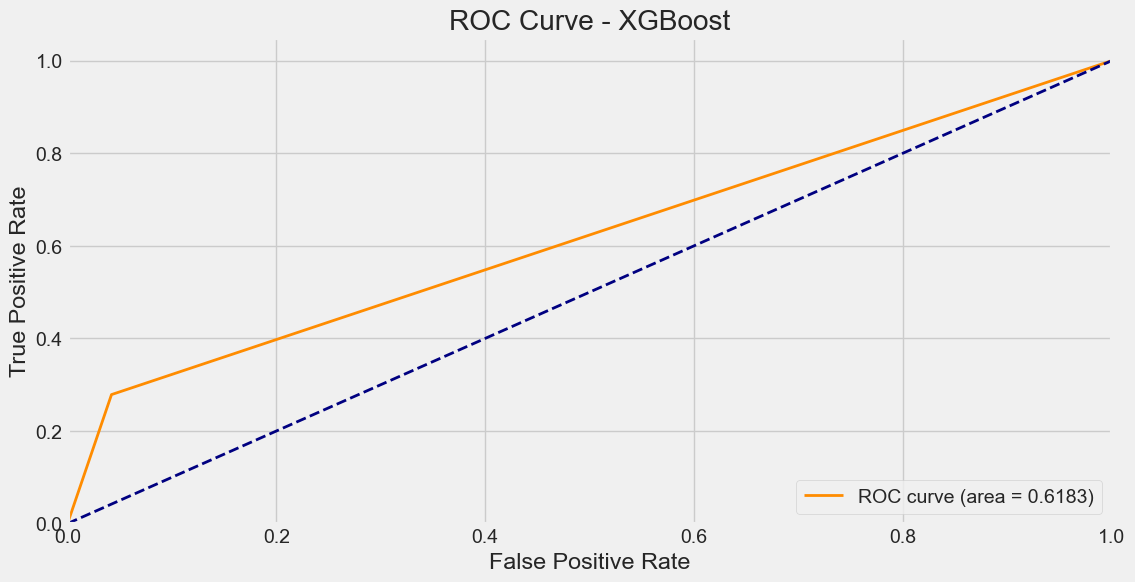

In [156]:
# Plotten der ROC-Kurve für XGBoost
plt.figure(figsize=(12, 6))
plt.plot(fpr_xgb_model, tpr_xgb_model, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_xgb_model:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")

##### 2.5 Vergleich Modell-Performance mit Originaldaten vs. bereinigte Daten (One-Hot-Encoding)

Verbessert sich die ROC-Curve, wenn XGBoost auf den Originaldaten (Kategoriale Variablen) anstatt auf den mittels One-Hot Encoding bereinigten Daten ausgeführt wird?

In [157]:
#Aufteilen der Daten in Zielvariable X und Attribute Y.
X_raw = employee_data_raw.drop('Attrition', axis=1)
y_raw = employee_data_raw.Attrition

#Aufteilen der Daten in Test und Trainingsdaten.
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.25, random_state=2)

# Textfeatures in Kategorien umwandeln
categories = X_train_raw.select_dtypes(include=object).columns.tolist()
for col in categories:
    X_train_raw[col] = X_train_raw[col].astype('category')
    X_test_raw[col] = X_test_raw[col].astype('category')

# Labels in numerische Codes umwandeln
if y_train_raw.dtype == 'object':
    y_train_raw = y_train_raw.astype('category')
    y_train_raw = y_train_raw.cat.codes

if y_test_raw.dtype == 'object':
    y_test_raw = y_test_raw.astype('category')
    y_test_raw = y_test_raw.cat.codes

# Erstellen der DMatrix
# DMatrix ist eine spezielle Datenstruktur, die von XGBoost verwendet wird.
# "enable_categorial=True" ermöglich die Verarbeitung kategorialer Daten

dtrain_reg = xgb.DMatrix(X_train_raw, y_train_raw, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test_raw, y_test_raw, enable_categorical=True)

# Modell trainieren

params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'eta': 0.3,
    'eval_metric': 'logloss'
}
xgb_model_raw = xgb.train(params, dtrain_reg, num_boost_round=100)

In [158]:
# Vorhersagen
y_pred_prob_raw = xgb_model_raw.predict(dtest_reg)
y_pred_raw = (y_pred_prob_raw > 0.5).astype(int)


# Genauigkeit berechnen
accuracy = accuracy_score(y_test_raw, y_pred_raw)
mse = mean_squared_error(y_test_raw, y_pred_prob_raw)
rmse = np.sqrt(mse)
auc = roc_auc_score(y_test_raw, y_pred_prob_raw) 
fpr, tpr, _ = roc_curve(y_test_raw, y_pred_prob_raw)

print(f"Accuracy: {accuracy}")
print(f"mse: {mse}")
print(f"rmse: {rmse}")
print(f"Area under Curve: {auc}")

Accuracy: 0.8586956521739131
mse: 0.11768001317977905
rmse: 0.3430452048778534
Area under Curve: 0.8113008644317942


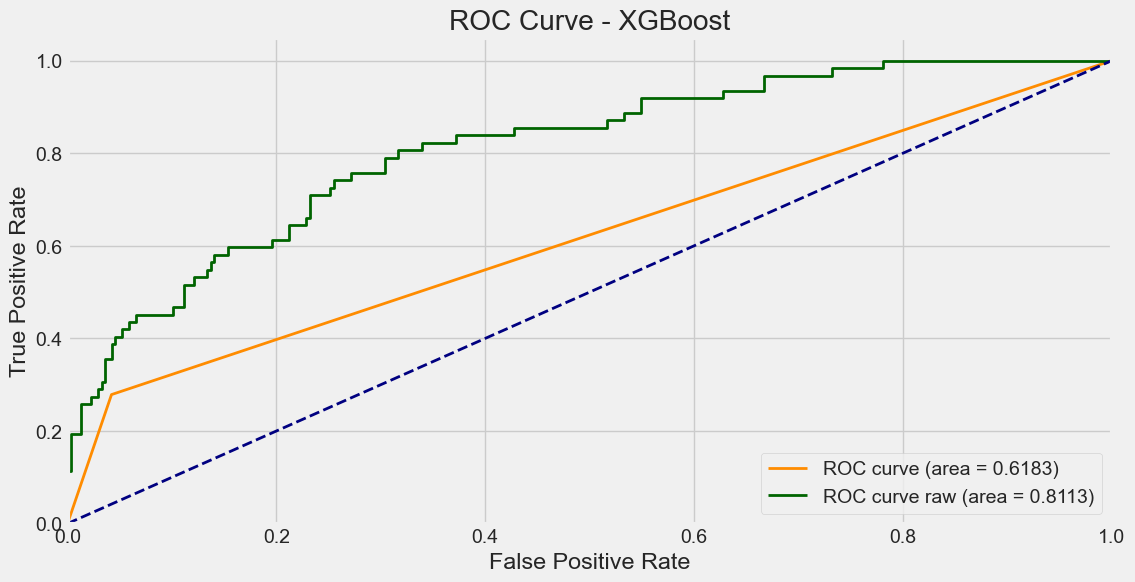

In [159]:
# Plotten der ROC-Kurve für XGBoost
plt.figure(figsize=(12, 6))
plt.plot(fpr_xgb_model, tpr_xgb_model, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_xgb_model:0.4f})')
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC curve raw (area = {auc:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")

#### 3. SVM

Die Support Vector Machine (SVM) ist ein überwachter Lernalgorithmus, der versucht das Risiko von Overfitting zu verringern. Bei der SVM wird jedes Mitglied des Trainingsdatensatzes einer vor zwei Kategorien zugewiesen, sodass es sich um einen nicht-probabilistischen binären linearen Klassifikator handelt. Bei einer linearen Klassifikation werden die Eingabetrainingsdatenpunkte in einem Raum (Hyperplane) abgebildet, jeder mit einem anderen Klassenlabel, das durch eine klare Lücke voneinander getrennt ist. Neue Datenpunkte werden dann in denselben Raum abgebildet und als Teil einer Klasse vorhergesagt, je nachdem, auf welcher Seite der Lücke sie liegen. SVM kann aber auch nicht-lineare Klassifikationen durchführen. Nebst der Robustheit gegenüber Überanpassung liegt der Vorteil in der Effektivität in hochdimensionalen Räumen (also wenn die Anzahl der Merkmale größer als die Anzahl an Beobachtungen ist). Durch verschiedene Kernel-Funktionen (darunter linear, polynominal und sigmoid) sind SVMs flexibel auf verschiedene Datensätze und Problemtypen einsetzbar. Allerdings gestaltet sich die Modellauswahl mitunter durch das Hyperparameter-Tuning und die Kernel-Auswahl als komplex. Unter der Modellkomplexität leidet ebenfalls die Interpretierbarkeit (Cortes und Vapnik 1995).

In [160]:
# Erstellen und trainieren des SVM Modells 
svm = SVC(kernel='rbf', C=1.0, probability=True, random_state=2)
svm.fit(X_train, y_train)
evaluate(svm, X_train,  X_test,  y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[853   0]
 [176   0]]
ACCURACY SCORE:
0.8290
CLASSIFICATION REPORT:
                    0      1  accuracy    macro avg  weighted avg
precision    0.828960    0.0   0.82896     0.414480      0.687175
recall       1.000000    0.0   0.82896     0.500000      0.828960
f1-score     0.906482    0.0   0.82896     0.453241      0.751438
support    853.000000  176.0   0.82896  1029.000000   1029.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[380   0]
 [ 61   0]]
ACCURACY SCORE:
0.8617
CLASSIFICATION REPORT:
                    0     1  accuracy   macro avg  weighted avg
precision    0.861678   0.0  0.861678    0.430839      0.742489
recall       1.000000   0.0  0.861678    0.500000      0.861678
f1-score     0.925700   0.0  0.861678    0.462850      0.797656
support    380.000000  61.0  0.861678  441.000000    441.000000


Mithilfe von GridSearch wird eine geeignete Parameterkombination identifiziert. 

In [161]:
svm = SVC(random_state=2)

param_grid = [
    {'C': [0.1, 1, 6, 10], 'gamma': [0.001, 0.005, 0.01], 'kernel': ['rbf']},
]


search = GridSearchCV(svm, param_grid=param_grid, scoring='roc_auc', cv=3, refit=True, verbose=1)
search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=SVC(random_state=2),
             param_grid=[{'C': [0.1, 1, 6, 10], 'gamma': [0.001, 0.005, 0.01],
                          'kernel': ['rbf']}],
             scoring='roc_auc', verbose=1)

Bei mehrmaligem Testen mit unterschiedlichen RandomStates wird deutlich, dass die geeigneten Parameterkombinationen stark voneinander abweichen. 

In [162]:
svm = SVC(**search.best_params_, probability=True)
svm.fit(X_train, y_train)

evaluate(svm, X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[848   5]
 [ 18 158]]
ACCURACY SCORE:
0.9776
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.979215    0.969325  0.977648     0.974270      0.977523
recall       0.994138    0.897727  0.977648     0.945933      0.977648
f1-score     0.986620    0.932153  0.977648     0.959387      0.977304
support    853.000000  176.000000  0.977648  1029.000000   1029.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[344  36]
 [ 57   4]]
ACCURACY SCORE:
0.7891
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.857855   0.100000  0.789116    0.478928      0.753027
recall       0.905263   0.065574  0.789116    0.485418      0.789116
f1-score     0.880922   0.079208  0.789116    0.480065      0.770027
support    380.000000  61.000000  0.789116  441.000000    441.000000


##### Visualisierung der Modellperformance

Die *ROC-Curve* (Receiver Operating Characteristic) ist ein Tool zur Bewertung der Leistung eines binären Klassifikationsmodells. Sie stellt die wahre positive Rate (True Positive Rate, TPR) gegenüber der falschen positiven Rate (False Positive Rate, FPR) dar, um die Trennschärfe des Modells bei verschiedenen Schwellenwerten zu visualisieren

In [163]:
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm.predict(X_test))
roc_auc_svm = roc_auc_score(y_test, svm.predict(X_test))

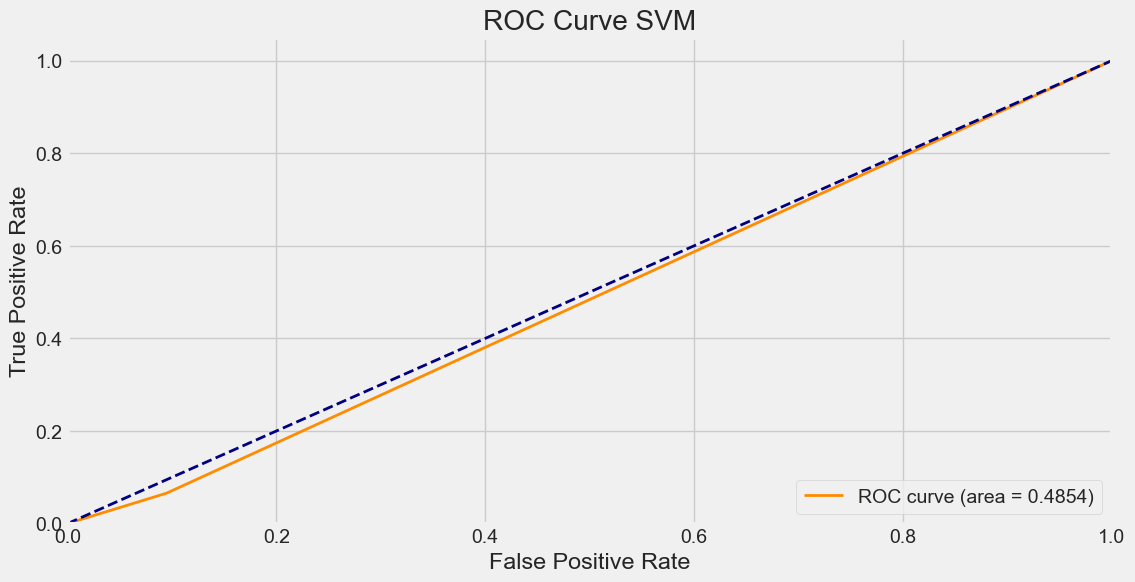

In [164]:
# Plotten der ROC-Kurve für SVM
plt.figure(figsize=(12, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_svm:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVM')
plt.legend(loc="lower right")

Um das Modell besser zu verstehen kann die Visualisierung mithilfe von SHAP und LIME durchgeführt werden. 

### Vergleich der Methoden 
Im Folgenden werden die zuvor angewendeten Modelle SVM, XGBoost und Random Forest verglichen um zu bewerten, welches Modell die besten Ergebnisse liefert. 

NameError: name 'auc_svm' is not defined

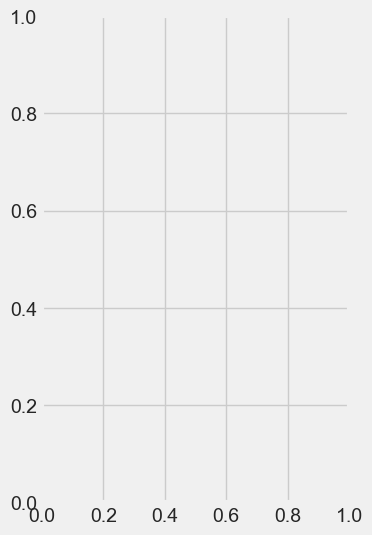

In [165]:
# Plotten der ROC-Kurven der verschiedenen Modelle
plt.figure(figsize=(12, 6))

# ROC-Kurve vor dem Tuning
plt.subplot(1, 3, 1)
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'ROC curve (area = {auc_svm:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVM')
plt.legend(loc="lower right")

# ROC-Kurve XGBoost
plt.subplot(1, 3, 2)
plt.plot(xxx, xxx, color='darkorange', lw=2, label=f'ROC curve (area = {xxx:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC XGBoost')
plt.legend(loc="lower right")

# ROC-Kurve Random Forest
plt.subplot(1, 3, 3)
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Random Forest')
plt.legend(loc="lower right")

plt.tight_layout()